## **Model Evaluation – XGBoost (Test Set)**

In diesem Notebook wird das final trainierte XGBoost-Modell auf einem vollständig unabhängigen Testdatensatz evaluiert.

Das Modell wurde zuvor im Modeling-Notebook trainiert und gespeichert.  
Der Testdatensatz wurde während des Trainings nicht verwendet und dient ausschließlich der finalen Leistungsbewertung.

Ziel dieser Evaluation ist es, die Generalisierungsfähigkeit des Modells zu prüfen und die Klassifikationsleistung unter realistischen Bedingungen zu analysieren.


In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve
)


## **Data Loading & Reproducibility**

Für eine saubere und reproduzierbare Evaluation wird:

- Der identische Datensatz geladen
- Der gleiche stratified Train-Test-Split mit identischem `random_state` verwendet
- Das gespeicherte Modell geladen

Durch diese Vorgehensweise wird sichergestellt, dass die Evaluation exakt unter denselben Bedingungen erfolgt wie im Modeling-Notebook.


In [2]:
DATA_PATH = "../data/processed/training_preprocessed.csv"

df = pd.read_csv(DATA_PATH)

TARGET = "FraudResult"

X = df.drop(columns=[TARGET])
y = df[TARGET]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [8]:
xgb_pipeline = joblib.load("xgb_pipeline.pkl")
y_pred_xgb = xgb_pipeline.predict(X_test)
y_proba = xgb_pipeline.predict_proba(X_test)[:, 1]

### **Interpretation**

Das Modell erreicht eine hohe Trennschärfe zwischen Betrug und Nicht-Betrug.

- Ein hoher Recall bedeutet, dass ein großer Anteil der Betrugsfälle erkannt wird.
- Die Precision zeigt, wie viele der gemeldeten Fälle tatsächlich Betrug sind.
- Der F1-Score bewertet das Gleichgewicht zwischen beiden Kennzahlen.

Bei stark unausgeglichenen Problemen ist ein Trade-off zwischen Precision und Recall üblich.


In [10]:
print("XGBoost - Testset Evaluation")
print(classification_report(y_test, y_pred_xgb))

roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")


XGBoost - Testset Evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19053
           1       0.85      0.87      0.86        39

    accuracy                           1.00     19092
   macro avg       0.92      0.94      0.93     19092
weighted avg       1.00      1.00      1.00     19092

ROC-AUC: 0.9999
PR-AUC: 0.9619


## Confusion Matrix

Die Confusion Matrix zeigt die absolute Anzahl von:

- True Positives (korrekt erkannter Betrug)
- False Positives (fälschlich gemeldeter Betrug)
- True Negatives
- False Negatives (übersehener Betrug)

Diese Darstellung ist besonders wichtig für die Business-Interpretation.


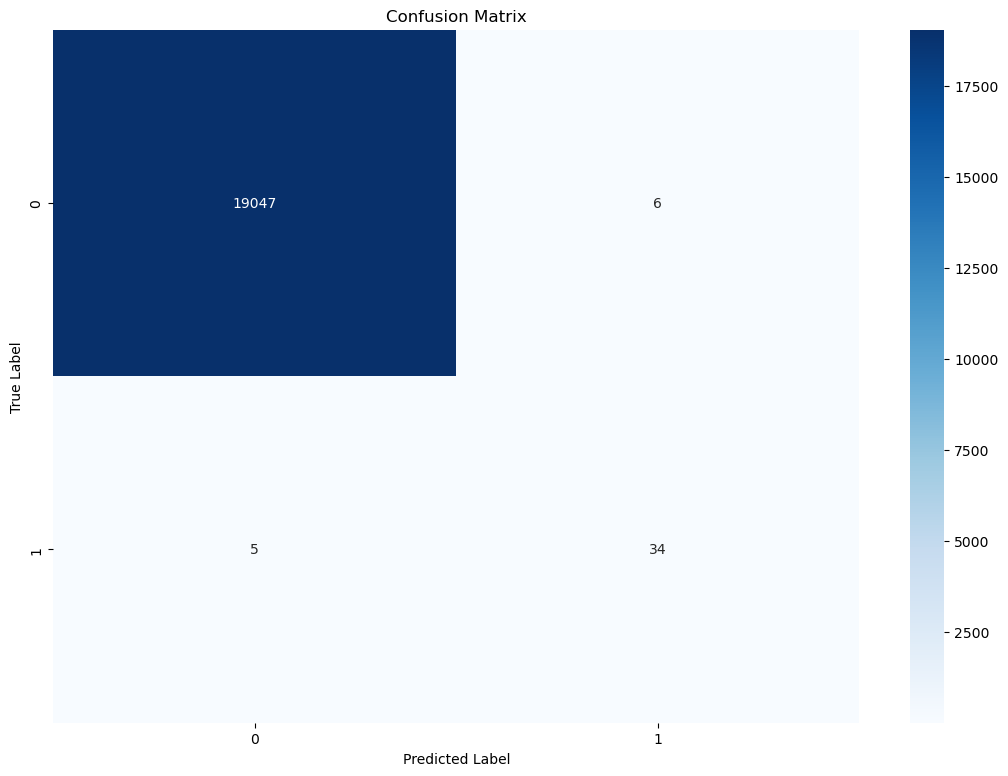

In [19]:
cm = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(13,9))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


## ROC-AUC

Die ROC-AUC misst die Trennschärfe des Modells über alle möglichen Klassifikationsschwellen hinweg.

Ein Wert nahe 1.0 zeigt eine sehr gute Fähigkeit des Modells, zwischen Betrug und Nicht-Betrug zu unterscheiden.

Die ROC-Kurve visualisiert den Trade-off zwischen:

- True Positive Rate (Recall)
- False Positive Rate


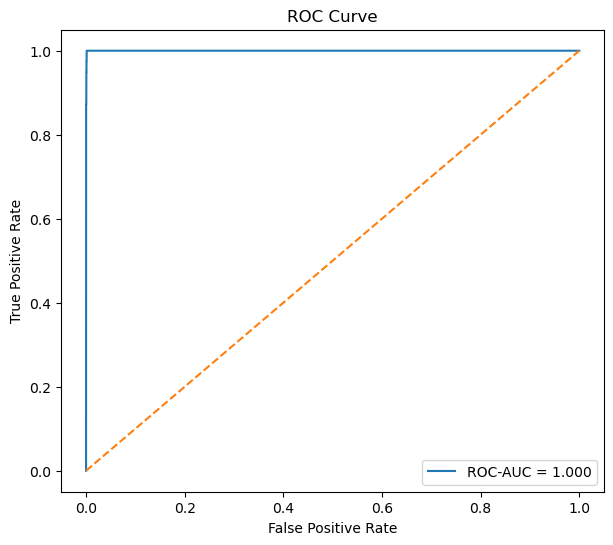

In [13]:
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


## Precision-Recall Curve

Die Precision-Recall-Kurve ist bei stark unausgeglichenen Datensätzen besonders aussagekräftig.

Sie zeigt den Zusammenhang zwischen:

- Recall (Erkennungsrate von Betrug)
- Precision (Qualität der Betrugsvorhersagen)

Die PR-AUC (Average Precision) fasst diese Kurve in einem einzigen Wert zusammen.


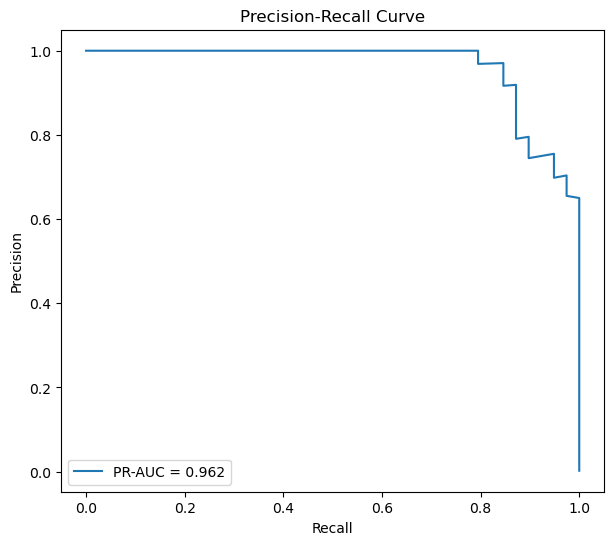

In [14]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(7,6))
plt.plot(recall, precision, label=f"PR-AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()
